In [1]:
from pynq import Overlay
from pynq import MMIO
from pynq import allocate
import pynq.lib.dma
import numpy as np
import cv2
%matplotlib inline
import matplotlib . pyplot as plt
import time

In [2]:
src = cv2.imread("lena-gray.png", cv2.IMREAD_GRAYSCALE)
print(src.shape)

(512, 512)


In [3]:
base = Overlay("./design_1.bit")
dir(base)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_deepcopy_dict_from',
 '_ip_map',
 '_register_drivers',
 'axi_dma_0',
 'axi_intc_0',
 'axi_timer_0',
 'binfile_name',
 'bit_data',
 'bitfile_name',
 'clock_dict',
 'device',
 'download',
 'dtbo',
 'firmware_path',
 'free',
 'gaussian_0',
 'gpio_dict',
 'hierarchy_dict',
 'ignore_version',
 'insert_dtbo',
 'interrupt_controllers',
 'interrupt_pins',
 'ip_dict',
 'is_loaded',
 'load_ip_data',
 'mem_dict',
 'parser',
 'partial',
 'pr_dict',
 'pr_download',
 'remove_dtbo',
 'reset',
 'timestamp',
 'zynq_ultra_ps_e_0']

In [4]:
dma = base.axi_dma_0
registers = base.gaussian_0.register_map

In [5]:
height = 512
width = 512
input_buffer = allocate(shape=(height,width), dtype=np.uint32, cacheable=False)
output_buffer = allocate(shape=(height,width), dtype=np.uint32, cacheable=False)
input_buffer[:] = src[:height, :width]
input_buffer.flush()

In [6]:
registers.CTRL.AP_START = 1
registers.CTRL.AUTO_RESTART = 1
dma.sendchannel.transfer(input_buffer)
dma.recvchannel.transfer(output_buffer)

In [7]:
dma.sendchannel.wait()
dma.recvchannel.wait()

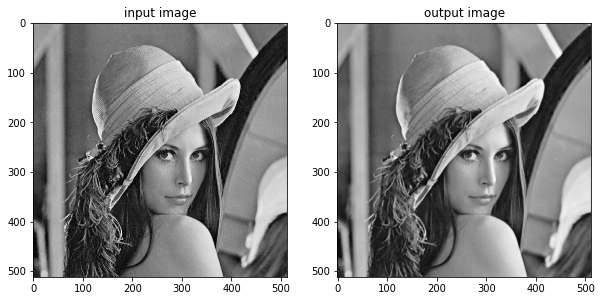

In [8]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(src, cmap = "gray")
plt.title("input image")

plt.subplot(1,2,2)
plt.imshow(output_buffer, cmap="gray")
plt.title("output image")
plt.show()

In [9]:
SIZE = height*width*4
LOOP = 1024
t0 = time.time()
for l in range(LOOP):
    dma.sendchannel.transfer(input_buffer)
    dma.recvchannel.transfer(output_buffer)
    dma.sendchannel.wait()
    dma.recvchannel.wait()

t1 = time.time()
print("Total elapsed time:", t1-t0, "s")
print("Elapsed time per picture:", ((t1-t0) / LOOP) * 1000, "ms")
print("Throughput:", (SIZE*LOOP) / 1024 / 1024 / (t1-t0), "MBps")

Total elapsed time: 2.9407832622528076 s
Elapsed time per picture: 2.8718586545437574 ms
Throughput: 348.20655202436024 MBps
